## Parte 2. Selección e Ingeniería de caracteristicas

In [2]:
# importar librerias
import numpy as np
import pandas as pd

In [3]:
df_processed = pd.read_csv('../data/processed/bike_sharing_processed.csv')
df_fe = df_processed.copy()

In [4]:
df_fe.shape

(17531, 18)

In [5]:
# Revisando tipado de datos
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17531 entries, 0 to 17530
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17531 non-null  object 
 1   season      17531 non-null  int64  
 2   yr          17531 non-null  int64  
 3   mnth        17531 non-null  int64  
 4   hr          17531 non-null  int64  
 5   holiday     17531 non-null  int64  
 6   weekday     17531 non-null  int64  
 7   workingday  17531 non-null  int64  
 8   weathersit  17531 non-null  int64  
 9   temp        17531 non-null  float64
 10  atemp       17531 non-null  float64
 11  hum         17531 non-null  float64
 12  windspeed   17531 non-null  float64
 13  casual      17531 non-null  float64
 14  registered  17531 non-null  float64
 15  cnt         17531 non-null  float64
 16  instant     17531 non-null  int64  
 17  dteday_dt   17531 non-null  object 
dtypes: float64(7), int64(9), object(2)
memory usage: 2.4+ MB


In [6]:
# fechas
if not np.issubdtype(df_fe['dteday'].dtype, np.datetime64):
    df_fe['dteday'] = pd.to_datetime(df_fe['dteday'], errors='coerce')

# datos con tipo de dato entero
for c in ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit','instant']:
    if c in df_fe:
        df_fe[c] = pd.to_numeric(df_fe[c], errors='coerce').round().astype('Int64')

# datos con tipo de dato continuo
for c in ['temp','atemp','hum','windspeed','cnt']:
    if c in df_fe:
        df_fe[c] = pd.to_numeric(df_fe[c], errors='coerce')

### Generamos más variables a partir de las existentes para ayudar a la interpretabilidad

In [7]:
# Temporales derivadas
df_fe['dayofyear'] = df_fe['dteday'].dt.dayofyear
df_fe['is_weekend'] = df_fe['weekday'].isin([0,6]).astype(int)

# Codificación cíclica: ayuda a que el modelo entienda que son ciclos
# hora (0-23)
df_fe['hr_sin']  = np.sin(2*np.pi * df_fe['hr'].astype(float) / 24.0)
df_fe['hr_cos']  = np.cos(2*np.pi * df_fe['hr'].astype(float) / 24.0)

# mes (1-12)
df_fe['mnth_sin'] = np.sin(2*np.pi * df_fe['mnth'].astype(float) / 12.0)
df_fe['mnth_cos'] = np.cos(2*np.pi * df_fe['mnth'].astype(float) / 12.0)

# día del año (1-366)
df_fe['doy_sin'] = np.sin(2*np.pi * df_fe['dayofyear'].astype(float) / 366.0)
df_fe['doy_cos'] = np.cos(2*np.pi * df_fe['dayofyear'].astype(float) / 366.0)

# Interacciones climáticas simples (no lineales y combinaciones útiles)
df_fe['temp_diff']  = df_fe['atemp'] - df_fe['temp']       # sensación - temperatura
df_fe['temp_x_hum'] = df_fe['temp'] * df_fe['hum']         # bochorno aproximado
df_fe['wind_sq']    = df_fe['windspeed'] ** 2              # relación no lineal con viento

In [8]:
# 5) Chequeo rápido
added = [
    'dayofyear','is_weekend',
    'hr_sin','hr_cos','mnth_sin','mnth_cos','doy_sin','doy_cos',
    'temp_diff','temp_x_hum','wind_sq'
]
print("Nuevas columnas:", added)
print("Shape antes:", df_processed.shape, "→ después:", df_fe.shape)
df_fe[added + ['cnt']].head(3)

Nuevas columnas: ['dayofyear', 'is_weekend', 'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos', 'doy_sin', 'doy_cos', 'temp_diff', 'temp_x_hum', 'wind_sq']
Shape antes: (17531, 18) → después: (17531, 29)


,dayofyear,is_weekend,hr_sin,hr_cos,mnth_sin,mnth_cos,doy_sin,doy_cos,temp_diff,temp_x_hum,wind_sq,cnt
0,1,0,0.000000,1.000000,0.5,0.866025,0.017166,0.999853,0.0479,0.1944,0.0,16.0
1,1,0,0.258819,0.965926,0.5,0.866025,0.017166,0.999853,0.0527,0.1760,0.0,40.0
2,1,0,0.500000,0.866025,0.5,0.866025,0.017166,0.999853,0.0527,0.1760,0.0,32.0


In [9]:
from sklearn.preprocessing import OneHotEncoder

# Copia del DF
df_enc = df_fe.copy()

# Solo las categóricas verdaderas
cat_cols = ['weekday', 'weathersit']

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df_enc[cat_cols])
encoded_cols = encoder.get_feature_names_out(cat_cols)
df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df_enc.index)

# Concatenamos
df_model = pd.concat([df_enc.drop(columns=cat_cols), df_encoded], axis=1)

print("Shape original:", df_fe.shape)
print("Shape con one-hot:", df_model.shape)
print("Nuevas columnas:", list(encoded_cols))
df_model.head(3)


Shape original: (17531, 29)
Shape con one-hot: (17531, 36)
Nuevas columnas: ['weekday_1.0', 'weekday_2.0', 'weekday_3.0', 'weekday_4.0', 'weekday_5.0', 'weekday_6.0', 'weathersit_2.0', 'weathersit_3.0', 'weathersit_4.0']


,dteday,season,yr,mnth,hr,holiday,workingday,temp,atemp,hum,...,wind_sq,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weathersit_2.0,weathersit_3.0,weathersit_4.0
0,2011-01-01,1,0,1,0,0,0,0.24,0.2879,0.81,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2011-01-01,1,0,1,1,0,0,0.22,0.2727,0.80,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2011-01-01,1,0,1,2,0,0,0.22,0.2727,0.80,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


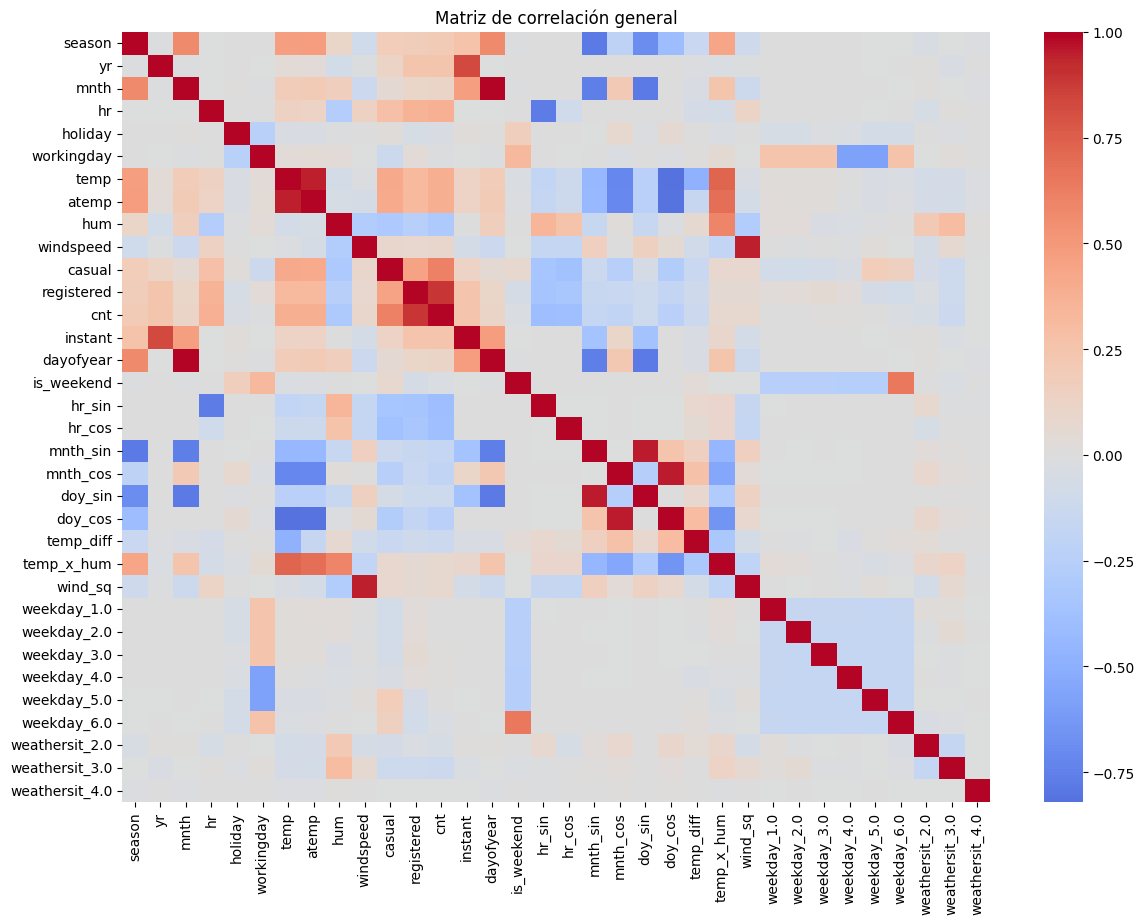

🔹 Correlación con 'cnt':
cnt            1.000000
registered     0.889995
casual         0.615240
temp           0.384201
atemp          0.383334
hr             0.380880
instant        0.259735
yr             0.241348
season         0.199822
mnth           0.117409
dayofyear      0.117081
windspeed      0.092897
wind_sq        0.073341
temp_x_hum     0.070579
weekday_4.0    0.016775
Name: cnt, dtype: float64

🔻 Menor correlación con 'cnt':
weathersit_2.0   -0.048956
doy_sin          -0.115715
weathersit_3.0   -0.125024
temp_diff        -0.130141
mnth_sin         -0.168724
mnth_cos         -0.192501
doy_cos          -0.232243
hum              -0.306229
hr_cos           -0.391827
hr_sin           -0.396989
Name: cnt, dtype: float64

⚠️ Pares altamente correlacionados (>0.9):


,feature_1,feature_2,corr
76,mnth,dayofyear,0.996493
183,temp,atemp,0.944456
275,windspeed,wind_sq,0.944869
442,mnth_sin,doy_sin,0.953208
457,mnth_cos,doy_cos,0.953027


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aseguramos que 'cnt' sea numérica
df_corr = df_model.copy()
df_corr['cnt'] = pd.to_numeric(df_corr['cnt'], errors='coerce')

# Correlaciones solo numéricas
corr = df_corr.corr(numeric_only=True)

# --- 1️⃣ Matriz de correlación general ---
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Matriz de correlación general")
plt.show()

# --- 2️⃣ Correlación con la variable objetivo ---
target_corr = corr['cnt'].sort_values(ascending=False)
print("🔹 Correlación con 'cnt':")
print(target_corr.head(15))
print("\n🔻 Menor correlación con 'cnt':")
print(target_corr.tail(10))

# --- 3️⃣ Identificar pares altamente correlacionados (>0.9) ---
threshold = 0.9
high_corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'corr'})
)
high_corr_pairs = high_corr_pairs.loc[abs(high_corr_pairs['corr']) > threshold]
print("\n⚠️ Pares altamente correlacionados (>0.9):")
display(high_corr_pairs)


In [11]:
# Eliminar variables redundantes
to_drop = ['dayofyear', 'atemp', 'wind_sq', 'doy_sin', 'doy_cos']
df_selected = df_model.drop(columns=to_drop, errors='ignore')

print("Shape antes:", df_model.shape)
print("Shape después:", df_selected.shape)


Shape antes: (17531, 36)
Shape después: (17531, 31)


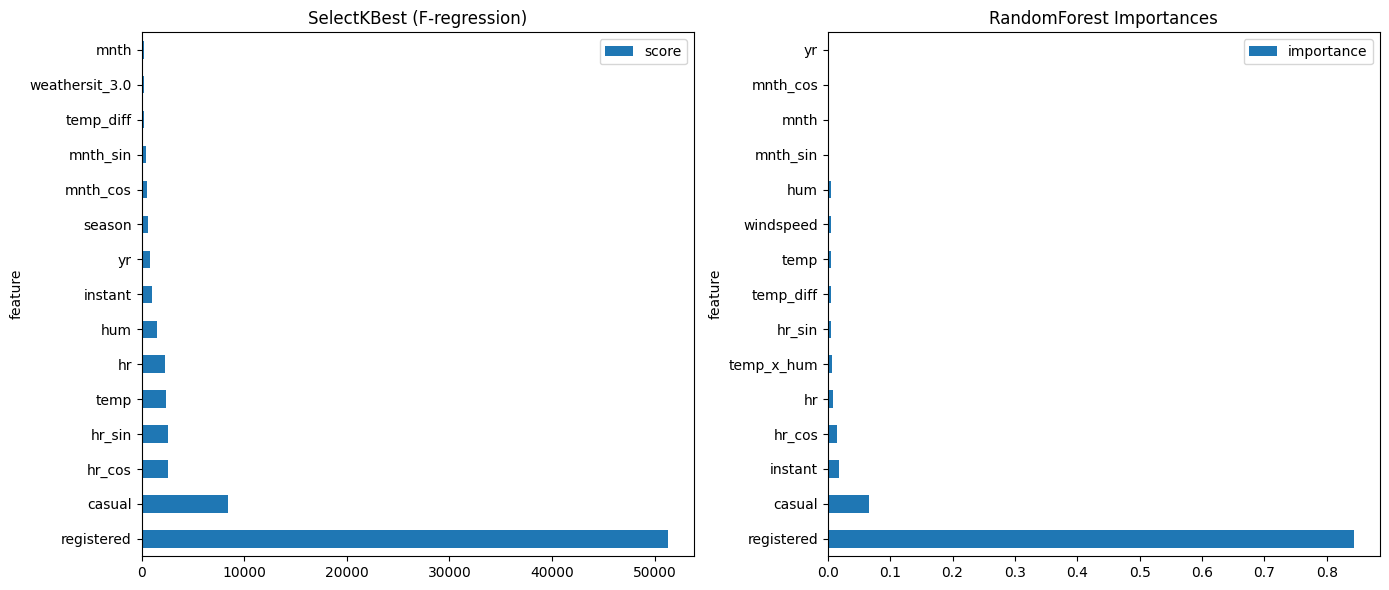

🔹 Top 10 ANOVA:


,feature,score
10,registered,51265.504881
9,casual,8454.585848
15,hr_cos,2561.617374
14,hr_sin,2536.375565
6,temp,2382.015843
3,hr,2319.766914
7,hum,1477.683088
11,instant,984.032327
1,yr,843.200569
0,season,574.430989



🔹 Top 10 RF:


,feature,importance
10,registered,0.843228
9,casual,0.065899
11,instant,0.017940
15,hr_cos,0.014295
3,hr,0.008284
19,temp_x_hum,0.006689
14,hr_sin,0.005528
18,temp_diff,0.005438
6,temp,0.004721
8,windspeed,0.004577


In [12]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- separar X / y
y = df_selected['cnt'].astype(float)
X = df_selected.drop(columns=['cnt'])

# 1) quitar columnas datetime (p. ej., 'dteday')
dt_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
X = X.drop(columns=dt_cols)

# 2) forzar numérico en todo (nullable Int64 -> float)
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors='coerce')

# 3) asegurar sin NaN (no debería haber, pero por si acaso)
if X.isna().any().any():
    X = X.fillna(0.0)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- SelectKBest (ANOVA/F-test)
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)
anova_scores = pd.DataFrame(
    {'feature': X.columns, 'score': selector.scores_}
).sort_values('score', ascending=False)

# --- Random Forest Importances
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_importances = pd.DataFrame(
    {'feature': X.columns, 'importance': rf.feature_importances_}
).sort_values('importance', ascending=False)

# --- plots rápidos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
anova_scores.head(15).plot.barh(x='feature', y='score', ax=axes[0])
axes[0].set_title('SelectKBest (F-regression)')
rf_importances.head(15).plot.barh(x='feature', y='importance', ax=axes[1])
axes[1].set_title('RandomForest Importances')
plt.tight_layout()
plt.show()

print("🔹 Top 10 ANOVA:")
display(anova_scores.head(10))
print("\n🔹 Top 10 RF:")
display(rf_importances.head(10))


In [13]:
features_final = [
    'temp', 'hum', 'windspeed',
    'season', 'yr', 'mnth', 'hr',
    'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos',
    'is_weekend', 'holiday', 'workingday',
    'weathersit_2.0', 'weathersit_3.0', 'weathersit_4.0',
    'temp_diff', 'temp_x_hum'
]


### Model training

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error


# asegurar tipos y quitar columnas no numéricas crudas
df_m = df_selected.copy()
df_m['dteday'] = pd.to_datetime(df_m['dteday'], errors='coerce')
for c in features_final + ['cnt']:
    df_m[c] = pd.to_numeric(df_m[c], errors='coerce')

# 3) split temporal
train = df_m[df_m['dteday'].dt.year == 2011].copy()
valid = df_m[df_m['dteday'].dt.year == 2012].copy()

X_train = train[features_final]
y_train = train['cnt'].astype(float)

X_valid = valid[features_final]
y_valid = valid['cnt'].astype(float)

print("Train:", X_train.shape, "| Valid:", X_valid.shape)


Train: (8730, 19) | Valid: (8801, 19)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_valid)

#rmse = mean_squared_error(y_valid, pred_rf, squared=False)
rmse = root_mean_squared_error(y_valid, pred_rf, squared=False)
mae  = mean_absolute_error(y_valid, pred_rf)
r2   = r2_score(y_valid, pred_rf)

print(f"[RF] VALID → RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}")


NameError: name 'rmse' is not defined

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=3.0, random_state=42))
])

pipe_ridge.fit(X_train, y_train)
pred_rg = pipe_ridge.predict(X_valid)

rmse_rg = mean_squared_error(y_valid, pred_rg, squared=False)
mae_rg  = mean_absolute_error(y_valid, pred_rg)
r2_rg   = r2_score(y_valid, pred_rg)

print(f"[Ridge] VALID → RMSE: {rmse_rg:.3f} | MAE: {mae_rg:.3f} | R2: {r2_rg:.3f}")


TypeError: got an unexpected keyword argument 'squared'

In [24]:
results = pd.DataFrame([
    {"model":"RandomForest", "RMSE":rmse, "MAE":mae, "R2":r2},
    {"model":"Ridge",        "RMSE":rmse_rg, "MAE":mae_rg, "R2":r2_rg},
])
results


NameError: name 'rmse' is not defined

In [25]:
df_m = df_m.sort_values(by='dteday').copy()
df_m['cnt_lag1'] = df_m['cnt'].shift(1)
df_m['cnt_lag24'] = df_m['cnt'].shift(24)
df_m['cnt_rolling_mean'] = df_m['cnt'].rolling(window=3).mean()

# eliminar primeras filas nulas por lag
df_m = df_m.dropna(subset=['cnt_lag1', 'cnt_lag24', 'cnt_rolling_mean'])
print(df_m[['cnt', 'cnt_lag1', 'cnt_lag24', 'cnt_rolling_mean']].head(10))


     cnt  cnt_lag1  cnt_lag24  cnt_rolling_mean
37  59.0       2.0       16.0         25.000000
46   8.0      59.0      415.0         23.000000
45   9.0       8.0       28.0         25.333333
44  31.0       9.0       34.0         16.000000
43  22.0      31.0       36.0         20.666667
42  30.0      22.0       37.0         27.666667
41  53.0      30.0       35.0         35.000000
40  65.0      53.0       93.0         49.333333
39  76.0      65.0      110.0         64.666667
38  74.0      76.0      106.0         71.666667


In [26]:
corr_lags = df_m[['cnt', 'cnt_lag1', 'cnt_lag24', 'cnt_rolling_mean']].corr()
corr_lags

,cnt,cnt_lag1,cnt_lag24,cnt_rolling_mean
cnt,1.000000,0.533789,0.258574,0.783938
cnt_lag1,0.533789,1.000000,0.246539,0.853787
cnt_lag24,0.258574,0.246539,1.000000,0.299009
cnt_rolling_mean,0.783938,0.853787,0.299009,1.000000


In [27]:
train = df_m[df_m['dteday'].dt.year == 2011].copy()
valid = df_m[df_m['dteday'].dt.year == 2012].copy()

X_train = train[features_final + ['cnt_lag1', 'cnt_lag24', 'cnt_rolling_mean']]
y_train = train['cnt'].astype(float)

X_valid = valid[features_final + ['cnt_lag1', 'cnt_lag24', 'cnt_rolling_mean']]
y_valid = valid['cnt'].astype(float)


In [28]:
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_valid)

rmse = mean_squared_error(y_valid, pred_rf, squared=False)
mae  = mean_absolute_error(y_valid, pred_rf)
r2   = r2_score(y_valid, pred_rf)

print(f"[RF + Lags] VALID → RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}")


TypeError: got an unexpected keyword argument 'squared'

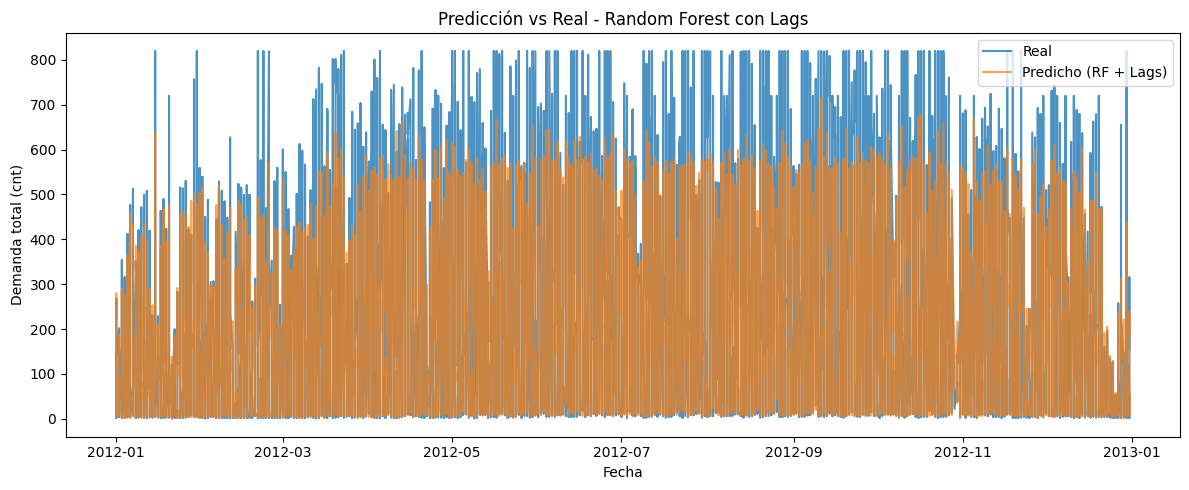

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(valid['dteday'], y_valid, label='Real', alpha=0.8)
plt.plot(valid['dteday'], pred_rf, label='Predicho (RF + Lags)', alpha=0.7)
plt.title('Predicción vs Real - Random Forest con Lags')
plt.xlabel('Fecha')
plt.ylabel('Demanda total (cnt)')
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
import joblib
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model_path = f"../models/random_forest_lags_{timestamp}.pkl"

joblib.dump(rf, model_path)
print(f"Modelo guardado en: {model_path}")


Modelo guardado en: ../models/random_forest_lags_20251116_0254.pkl
